# 导包模板

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

import pandas as pd
import torchvision
from torchvision import transforms, models
import os

from lxml import etree # 解析xml
from matplotlib.patches import Rectangle  # 绘制矩形
import glob

from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 图像定位

## 数据预处理 宠物头部定位
The Oxford-IIIT Pet Dataset是一个宠物图像数据集,包含37种宠物,每种宠物200张左右宠物图片,该数据集同时包含宠物分类、头部轮廊标注和语义分割信息。

In [2]:
images = glob.glob(r'../data/Oxford-IIIT Pets Dataset/images/*.jpg')  # 7390
xmls = glob.glob(r"../data/Oxford-IIIT Pets Dataset/annotations/xmls/*.xml")  # 部分有标记 3686
xmls_names = [x.split('\\')[-1].split('.xml')[0] for x in xmls]  # 所有有标记的图片名称
imgs = [img for img in images if img.split('\\')[-1].split('.jpg')[0] in xmls_names]  # 找到有标记的图片路径
# imgs,xmls 都是一一对应的，如果不先处理序号，则都是1 10 100 2这种

def to_labels(path):
    """从xml中读取标记的矩形框，返回比例值"""
    xml = open(r'{}'.format(path)).read()
    sel = etree.HTML(xml)  # 选择器
    width = int(sel.xpath('//size/width/text()')[0])
    height = int(sel.xpath('//size/height/text()')[0])
    xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
    ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
    xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
    ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
    return [xmin/width, ymin/height, xmax/width, ymax/height]
labels = [to_labels(path) for path in xmls]  # 将xml内矩形提取出来转为label，比例表示

index = np.random.permutation(len(imgs))  # 打乱并划分训练集和测试集
imgs = np.array(imgs)[index]
labels = np.array(labels)[index].astype(np.float32)
s = int(len(imgs)*0.8)
train_imgs, train_labels = imgs[:s], labels[:s]
test_imgs, test_labels = imgs[s:], labels[s:]

# 创建DataSet
transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor()
])
class OxfordDataset(Dataset):
    def __init__(self, img_paths, labels_list ,transform):
        self.imgs = img_paths  # 路径列表
        self.labels = labels_list
        self.transforms = transform
    def __getitem__(self, index):
        """返回img和对应的矩形框(比例表示)"""
        """ BUG：stack expects each tensor to be equal size, but got [1, 224, 224] at entry 0 and [3, 224, 224] at entry 1
            MD居然是文件中有一张黑白图片，解决方法：Image.open(self.imgs[index]).convert("RGB") 全部以RGB方式读取 """
        img_tensor = self.transforms(Image.open(self.imgs[index]).convert("RGB"))
        xmin, ymin, xmax, ymax = (self.labels[index][i] for i in range(4))
        return img_tensor, xmin, ymin, xmax, ymax
    def __len__(self):
        return len(self.imgs)

train_ds = OxfordDataset(train_imgs, train_labels, transform)
test_ds = OxfordDataset(test_imgs, test_labels, transform)
BATCHSIZE=8
train_dl = DataLoader(train_ds, batch_size=BATCHSIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCHSIZE)

### 显示图片 show_img

In [36]:
def show_img(dataloader, size=3, transform_size=224):
    """
    显示前6张图片
    :param size: 每张图片显示大小
    :param transform_size: transform中resize的大小
    """
    imgs, xmin, ymin, xmax, ymax = next(iter(dataloader))
    s = 6  # 显示前几个图片
    plt.figure(figsize=(s*size, 1*size))
    for i, (img, x1, y1, x2, y2) in enumerate(zip(imgs[:s], xmin[:s], ymin[:s], xmax[:s], ymax[:s])):
        img = img.permute(1, 2, 0).numpy()  # 改变维度 toTensor的逆操作
        # img = (img+1)/2 # 从(-1,1)转化到(0,1)  标准化的逆操作
        plt.subplot(1, 6, i+1)  # 子图
        plt.imshow(img)  # 显示图片
        x1, y1, x2, y2 = [i*transform_size for i in [x1, y1, x2, y2]]  # 转为实际的宽和高
        rect = Rectangle((x1, y1), (x2-x1), (y2-y1), fill=False, color='red')  # 矩形框坐标
        ax = plt.gca()  # 获取当前坐标系
        ax.axes.add_patch(rect)  # 绘制矩形

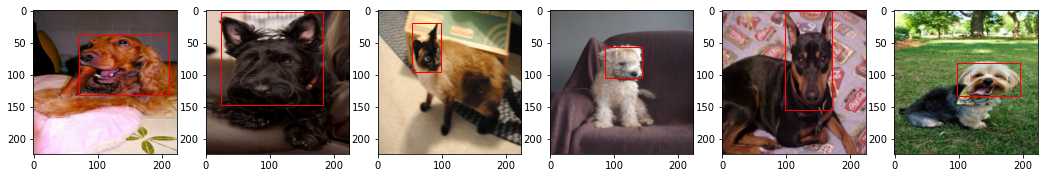

In [25]:
show_img(train_dl)  # 看看长啥样

## 创建定位模型
预训练模型 C:\Users\李浩然\.cache\torch\hub\checkpoints\resnet101-63fe2227.pth

In [3]:
resnet = torchvision.models.resnet101(pretrained=True)  # avgpool前的都需要
in_size = resnet.fc.in_features  # 卷积基最后的输出2048
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_base = nn.Sequential(*list(resnet.children())[:-1])  # 提取卷积基
        self.fc1 = nn.Linear(in_size, 1)  # 输出4个值，代表相对位置xmin, ymin, xmax, ymax
        self.fc2 = nn.Linear(in_size, 1)
        self.fc3 = nn.Linear(in_size, 1)
        self.fc4 = nn.Linear(in_size, 1)

    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.size(0), -1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        x4 = self.fc4(x)
        return x1, x2, x3, x4

model = Net()
torch.cuda.empty_cache()  # 清空一下，否则会爆显存
model.to(device)

Net(
  (conv_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

## 训练模型

### 训练 fit
4个输出 xmin, ymin, xmax, ymax

In [8]:
def fit(epoch, model, trainloader, testloader):
    """输入模型、输入数据(train_dl, test_dl)， 对数据输入在模型上训练，并返回loss变化"""
    running_loss = 0
    model.train()  # 训练模式 dropout BN发挥作用
    for img, x1, y1, x2, y2 in trainloader:  # 对应xmin, ymin, xmax, ymax
        var = (print(i.shape) for i in [img, x1, y1, x2, y2])
        img = img.to(device)
        y = (i.to(device) for i in [x1, y1, x2, y2])
        y_pred = model(img)
        l1, l2, l3, l4 = (loss_fn(i_pred, i) for i, i_pred in zip(y, y_pred))
        loss = l1+l2+l3+l4
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            running_loss += loss.item()

    # lr_decay.step()  # 学习率衰减
    epoch_loss = running_loss / len(trainloader.dataset)  # 平均loss

    test_running_loss = 0
    model.eval()  # 预测模式 dropout BN不发挥作用
    with torch.no_grad():
        for img, x1, y1, x2, y2 in testloader:
            img = img.to(device)
            y = (i.to(device) for i in [x1, y1, x2, y2])
            y_pred = model(img)
            l1, l2, l3, l4 = (loss_fn(i_pred, i) for i, i_pred in zip(y, y_pred))
            loss = l1+l2+l3+l4
            test_running_loss += loss.item()

    epoch_test_loss = test_running_loss / len(testloader.dataset)

    print('epoch:', epoch,
          'loss:', round(epoch_loss, 3),
          'test_loss:', round(epoch_test_loss, 3),
             )

    return epoch_loss, epoch_test_loss

### 显示损失 show_loss
回归问题，没有必要计算准确率

In [5]:
def show_loss(train_loss, test_loss):
    plt.figure()
    plt.plot(range(1, epochs+1), train_loss, 'r', label='train_loss')
    plt.plot(range(1, epochs+1), test_loss, 'bo', label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.show()

### 开始训练

E:\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return

epoch: 0 loss: 0.018 test_loss: 0.011
epoch: 1 loss: 0.012 test_loss: 0.011
epoch: 2 loss: 0.012 test_loss: 0.077
epoch: 3 loss: 0.012 test_loss: 0.013
epoch: 4 loss: 0.012 test_loss: 0.433


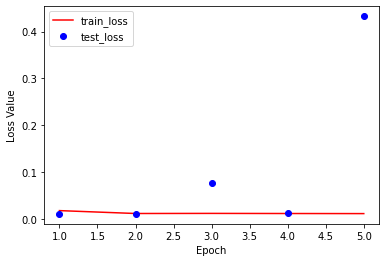

In [6]:
# 损失函数和优化器
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
# lr_decay = lr_scheduler.StepLR(optim, step_size=7, gamma=0.1)

# 开始训练 (模型太复杂，小GPU吃不消)
epochs = 5
train_loss = []
test_loss = []
for epoch in range(epochs):
    epoch_loss, epoch_test_loss = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)

show_loss(train_loss, test_loss)

## 模型保存与预测

In [30]:
PATH = 'model/Oxford.pth'
torch.save(model.state_dict(), PATH)

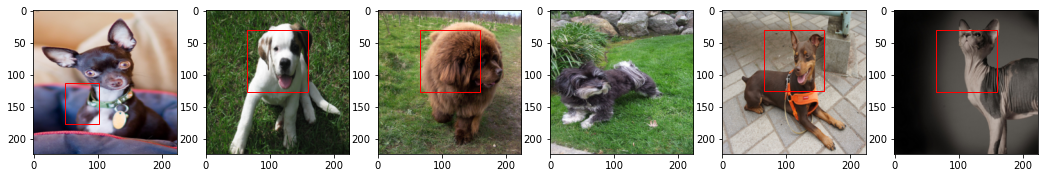

In [7]:
# 预测模型
plt.figure(figsize=(18, 3))
imgs, _, _, _, _ = next(iter(test_dl))
imgs = imgs.to(device)
out1, out2, out3, out4 = model(imgs)
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(imgs[i].permute(1,2,0).cpu().numpy())
    xmin, ymin, xmax, ymax = (out[i].item()*224 for out in [out1, out2, out3, out4])
    rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
    ax = plt.gca()
    ax.axes.add_patch(rect)

# 目标检测 SSD

## 数据预处理 香蕉定位
香蕉检测与定位，图片大小全部为256x256x24，[视频](https://www.bilibili.com/video/BV1Lh411Y7LX)

In [3]:
train_data_dir = r"../data/banana-detection/bananas_train/images/*.png"
test_data_dir = r"../data/banana-detection/bananas_val/images/*.png"
train_label_dir = r"../data/banana-detection/bananas_train/label.csv"
test_label_dir = r"../data/banana-detection/bananas_val/label.csv"

class BananasDataset(Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, data_dir, label_dir):
        self.imgs = glob.glob(data_dir)  # 注意排序问题(提前改名)
        self.labels = pd.read_csv(label_dir).set_index("img_name")
        self.transform = transforms.ToTensor()

    def __getitem__(self, idx):
        image = self.transform(Image.open(self.imgs[idx]))  # 256*256*24
        row = self.labels.iloc[idx]
        # print(idx, self.imgs[idx],row.name)
        label = row["label"]
        xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
        xmin, ymin, xmax, ymax = (x/256.0 for x in [xmin, ymin, xmax, ymax])
        return image, xmin, ymin, xmax, ymax

    def __len__(self):
        return len(self.imgs)

train_ds = BananasDataset(train_data_dir, train_label_dir)
test_ds = BananasDataset(test_data_dir, test_label_dir)

batch_size = 8
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size)

In [4]:
def show_img(dataloader, size=3, transform_size=256):
    """ 显示前6张图片
    :param size: 每张图片显示大小
    :param transform_size: transform中resize的大小  """
    imgs, xmin, ymin, xmax, ymax = next(iter(dataloader))
    s = 6  # 显示前几个图片
    plt.figure(figsize=(s*size, 1*size))
    for i, (img, x1, y1, x2, y2) in enumerate(zip(imgs[:s], xmin[:s], ymin[:s], xmax[:s], ymax[:s])):
        img = img.permute(1, 2, 0).numpy()  # 改变维度 toTensor的逆操作
        plt.subplot(1, 6, i+1)  # 子图
        plt.imshow(img)  # 显示图片
        x1, y1, x2, y2 = [i*transform_size for i in [x1, y1, x2, y2]]  # 转为实际的宽和高
        rect = Rectangle((x1, y1), (x2-x1), (y2-y1), fill=False, color='red')  # 矩形框坐标
        ax = plt.gca()  # 获取当前坐标系
        ax.axes.add_patch(rect)  # 绘制矩形

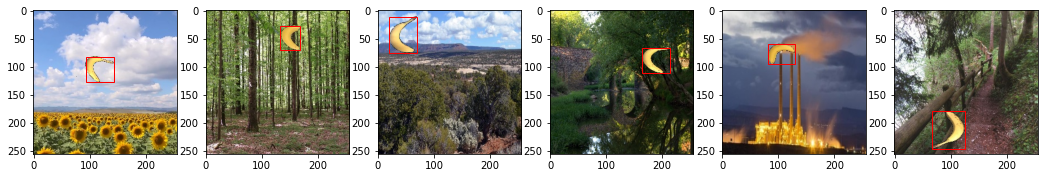

In [5]:
show_img(train_dl, 3, 256)

# R-CNN

# YOLOv3